In [1]:
# Import necessary libraries
import os
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, InputLayer, ReLU

%matplotlib inline



In [2]:
# Initialize a sequential model
model = Sequential(name="Receptive_field")

# First conv layer
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))

# Second conv layer
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# First max pooling layer
model.add(MaxPooling2D((2, 2)))

# Third conv layer
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Fourth conv layer
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Second max pooling layer
model.add(MaxPooling2D((2, 2)))

# Fifth conv layer
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Sixth conv layer
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

# Third max pooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected dense layer
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))

# Fully connected dense layer
model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))

# Output layer
model.add(Dense(10, activation='softmax'))

# Compiling the model
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
model.summary()

Model: "Receptive_field"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)     

In [4]:
model.load_weights("receptive_field_weights.h5")

# GETTING THE ACTIVATIONS

In [5]:
# Function to load the images given the file path
def load_image(img_path):

    img = image.load_img(img_path, target_size=(32, 32))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor = preprocess_input(img_tensor)               # imshow expects values in the range [0, 1]

    return img_tensor

In [6]:
path = "cifar/"
dirs = os.listdir(path)
layer_num = 7
activation_num=5

# Get model outputs
inp = model.input
outputs = [layer.output for layer in model.layers]
functors = [K.function([inp],[out]) for out in outputs]

acts = []


for i in range(1,51):
  # Get path of images
  file_path = path+"img"+str(i)+".jpg"

  # Call the load_image function defined above to get the images
  img_path = load_image(file_path)

  # Get the model layer outputs
  layer_outs = [func([img_path]) for func in functors]
  last = layer_outs[layer_num]

  # Get the feature maps
  feature_map = last[0]

  # Select one activation out of the feature map set
  num_act = activation_num

  # Get the selected activation
  select_act = feature_map[0][:,:,num_act]

  # Save the selected activation to a list
  acts.append(select_act.flatten())

In [7]:
# Dictionary of pixel wise best image activation

# Define a dictionary to hold the pixel-wise image that activates it the most
best_img = {}

# Loop over the entire pixel space of the selected activation
for j in range(model.layers[layer_num].output_shape[1]*model.layers[layer_num].output_shape[2]):
  l = []
  for i in range(len(acts)):
    l.append(acts[i][j])
  best_img[j] = np.argmax(l)+1



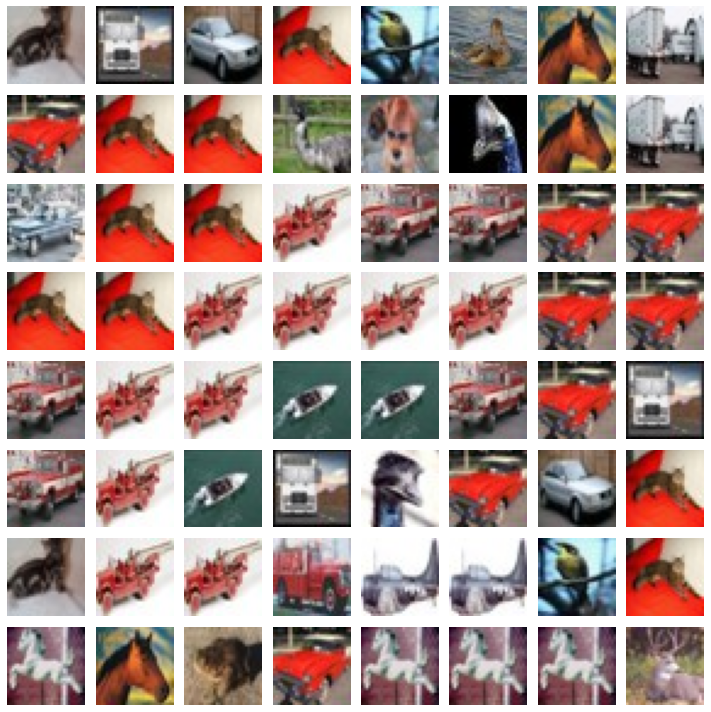

In [8]:
# Code to plot the receptive fields associated with each pixel

# print("Layer number: "+str(layer_num))
# print("Receptive field size: ", int(np.array(com[layer_num])[3]))

fig, ax = plt.subplots(model.layers[layer_num].output_shape[1], model.layers[layer_num].output_shape[2], figsize = (10,10))
counter = 0
# Loop over the possible pixel values of the feature map to plot the receptive fiels
for i in range(8):
  for j in range(8):

    # Denormalize the pixel values
    img_path = path+"img"+str(best_img[counter])+".jpg"
    ax[i][j].imshow((load_image(img_path).squeeze()/2)+0.5)
    #ax[i][i].set_title(rf_dict[counter].shape)
    ax[i][j].axis('off')
    counter+=1
 
plt.tight_layout()


# SETUP THE PADDING, KERNEL AND STRIDES

In [9]:
# Get the model padding, kernel and stride list
pad = [1,1,0,1,1,0,1,1,0]
ker = [3,3,2,3,3,2,3,3,2]
strd = [1,1,2,1,1,2,1,1,2]

# Define a function to get a dictionary that is of the following form
# [layer name]:{kernel, stride, padding}
def make_arch(model):
  c = 0
  arc_dict = {}
  for i in model.layers[:9]:
    l = []
    l.append(ker[c])
    l.append(strd[c])
    l.append(pad[c])
    c+=1
    arc_dict[i.name] = l
  return arc_dict

# Call the above defined make_arch function
arc_dict = make_arch(model)

In [10]:
# Class to compute the receptive field size and start

class ComputeReceptiveField():
    def calculate(self, architecture, input_image_size):
        arc = []
        input_layer = ('input_layer', input_image_size, 1, 1, 0.5)
        #self._print_layer_info(input_layer)
        arc.append(input_layer)
        for key in architecture:
            current_layer = self._calculate_layer_info(architecture[key], input_layer, key)
            input_layer = current_layer
            arc.append(current_layer)
        return arc
            
            
    def _calculate_layer_info(self, current_layer, input_layer, layer_name):
        n_in = input_layer[1]
        j_in = input_layer[2]
        r_in = input_layer[3]
        start_in = input_layer[4]
        
        k = current_layer[0]
        s = current_layer[1]
        p = current_layer[2]

        n_out = math.floor((n_in - k + 2*p)/s) + 1
        padding = (n_out-1)*s - n_in + k 
        p_right = math.ceil(padding/2)
        p_left = math.floor(padding/2)
        

        j_out = j_in * s
        r_out = r_in + (k - 1)*j_in
        start_out = start_in + ((k-1)/2 - p_left)*j_in
        return layer_name, n_out, j_out, r_out, start_out

In [11]:
rf = ComputeReceptiveField()

# layer name, n[output size],j[cummulative stride] ,r[receptive field size], s[start]
com = rf.calculate(arc_dict, 32)


In [12]:
# Get the receptive field of the input image i.e. patch seen by each pixel of the feature map

def get_rf(img, y_pix=0, x_pix=0, ln=7):

  # Get the layer_number  
  layer_num = ln

  # Get the start point i.e. the center pixel of the receptive field
  start = float(np.array(com[layer_num])[4]) + x_pix

  # Get the size of the receptive field
  rf = int(np.array(com[layer_num])[3])

  # Get the leftmost pixel of the receptive patch
  lt = start - math.ceil(rf/2) 

  # Get the rightmost pixel of the receptive patch
  rt = start + math.ceil(rf/2) 

  # Get the topmost pixel of the receptive patch
  top = start - math.ceil(rf/2) + y_pix

  # Get the bottom-most pixel of the receptive patch
  btm = start + math.ceil(rf/2) + y_pix

  # Clip the left pixel if it lower than 0
  if lt<0:
    lt=0

  # Clip the right pixel if it is higher than the max size of the input
  if rt>img[0].shape[0]:
    rt=img[0].shape[0]-1

  # Clip the top if it is lower than 0
  if top<0:
    top=0

  # Clip the bottom if it is higher than the max size of the input 
  if btm>img[0].shape[1]:
    btm=img[0].shape[1]-1

  # Get the receptive field from the input image
  img_rf = img[0][int(lt):int(rt), int(top):int(btm), :]

  # Return the receptive field
  return img_rf


In [13]:
# Define a dictionary to store the receptive field associated to each pixel
rf_dict = {}

# Run a counter to use as dictionary keys
counter=0

# Loop over the possible pixel values of the feature map to get the receptive fiels
for i in range(model.layers[layer_num].output_shape[1]):
  for j in range(model.layers[layer_num].output_shape[2]):

    # Call the load_image function that is defined as the best for each pixel
    img = load_image("cifar/img"+str(best_img[counter])+".jpg")

    # Call the get_rf function to get the receptive field for that pixel and previously loaded image
    img_rf = get_rf(img, i, j, layer_num)

    # Save the returned receptive field as the values of the dictionary
    rf_dict[counter] = img_rf

    # Increment the counter
    counter+=1


Layer number: 7
Receptive field size:  24


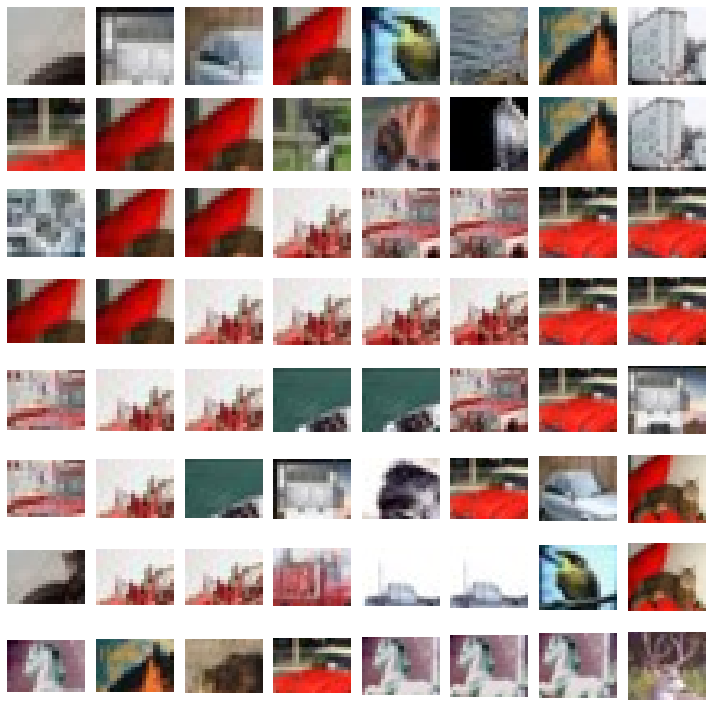

In [14]:
# Code to plot the receptive fields associated with each pixel

print("Layer number: "+str(layer_num))
print("Receptive field size: ", int(np.array(com[layer_num])[3]))

fig, ax = plt.subplots(model.layers[layer_num].output_shape[1], model.layers[layer_num].output_shape[2], figsize = (10,10))
counter = 0

# Loop over the possible pixel values of the feature map to plot the receptive fiels
for i in range(model.layers[layer_num].output_shape[1]):
  for j in range(model.layers[layer_num].output_shape[2]):

    # Denormalize the pixel values
    ax[i][j].imshow((rf_dict[counter]/2)+0.5)
    #ax[i][i].set_title(rf_dict[counter].shape)
    ax[i][j].axis('off')
    counter+=1
 
plt.tight_layout()
